**3-layer Neural network for non-linear regression from scratch using Jax**

Plotting 3d non linear cubic equation data. Weights as 1,2,3

n denotes number of input data points

d denotes dimension

x is the set random n number of points generated in d dimensions

calculating actual values of y as y_true using x, actuals weights and bias

plotting x and y

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import plotly.graph_objects as go

Using jax numpy to generate 100 random data points for x and calculate y

In [2]:
def plot_4d(x, y, y_pred=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y.flatten(), cmap='Blues_r', label='underlying function')
    if y_pred is not None:
        ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y_pred.flatten(), cmap='Reds_r', label='our function')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()

x: (100, 3), weights: (3, 1), bias: (1,), y: (100, 1)


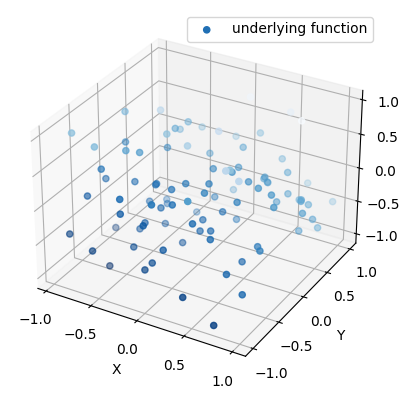

In [3]:
n = 100
d = 3
key = random.PRNGKey(0)
x = random.uniform(key, (n, d), minval=-1, maxval=1)

weights_true = np.array([[1, 2, 3]]).T
bias_true = np.array([1])

y_true = (x ** 3) @ weights_true + (x ** 2) @ weights_true + x @ weights_true + bias_true


print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

plot_4d(x, y_true)


Using Gradient descent and mean sum of square errors to calculate the loss and gradient, to update the weights and bias such that loss is minized

In [4]:
class MSE:
    def __call__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        return jnp.mean((y_pred - y_true) ** 2)

    def backward(self):
      n = self.y_true.shape[0]
      self.gradient = 2. * (self.y_pred - self.y_true) / n
      return self.gradient

First the weights and bias are initialized to a random value

Then calculate output by multiplying input with weights and adding bias

In backward function, the weights gradient and bias gradient are calculated based on the gradient values calculated

The weights and bias values are then updated in the update method

In [5]:
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    key = random.PRNGKey(0)
    #x = random.uniform(key, (n, d), minval=-1, maxval=1)
    self.weights = random.uniform(key, (input_dim, num_hidden)) * jnp.sqrt(2. / input_dim)
    self.bias = jnp.zeros(num_hidden)

  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

In [6]:
from typing import Callable

def fit(x: jnp.ndarray, y: jnp.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

Training with linear function

Using the linear function to train the non-linear data results in the loss being high, because the linear function is incapable of representing the this data

Epoch 0, loss 16.700050354003906
Epoch 1, loss 13.188725471496582
Epoch 2, loss 10.732563018798828
Epoch 3, loss 8.973366737365723
Epoch 4, loss 7.680229187011719
Epoch 5, loss 6.703589916229248
Epoch 6, loss 5.945963382720947
Epoch 7, loss 5.34327507019043
Epoch 8, loss 4.852946758270264
Epoch 9, loss 4.446293830871582
Epoch 10, loss 4.103658199310303
Epoch 11, loss 3.8112897872924805
Epoch 12, loss 3.559342622756958
Epoch 13, loss 3.340583086013794
Epoch 14, loss 3.1495518684387207
Epoch 15, loss 2.9820196628570557
Epoch 16, loss 2.834625482559204
Epoch 17, loss 2.704638719558716
Epoch 18, loss 2.589799642562866
Epoch 19, loss 2.488206386566162
Epoch 20, loss 2.398240089416504
Epoch 21, loss 2.318507432937622
Epoch 22, loss 2.247800588607788
Epoch 23, loss 2.1850674152374268
Epoch 24, loss 2.1293864250183105
Epoch 25, loss 2.0799481868743896
Epoch 26, loss 2.0360400676727295
Epoch 27, loss 1.9970333576202393
Epoch 28, loss 1.962372899055481
Epoch 29, loss 1.9315685033798218
Epoch 30,

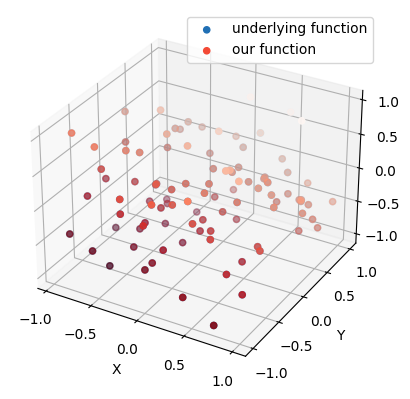

In [7]:
loss = MSE()
linear = Linear(d)
fit(x, y_true, model=linear, loss=loss, lr=0.1, num_epochs=100)
plot_4d(x, y_true, linear(x))

Introducing non-linearity in the neural network with a non-linear activation function - Relu. This enables the network to model complex relationships between input and output variables.

Without non-linear function, the output of each neuron would be a linear combination of the input variables - results in linear model - limitation in representing complex patterns in data

Some non-linear functions used : sigmoid, ReLU, Tanh.
Model complex relationships between input and output variables and learn more complex patterns in data

In [8]:
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = jnp.clip(self.input_, 0, None)
        return self.output

    def backward(self, output_gradient):
      #to debug
      #import pdb
      #pdb.set_trace()
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient

Performing just one step of:
- forward pass
- backward propagation

32.701996


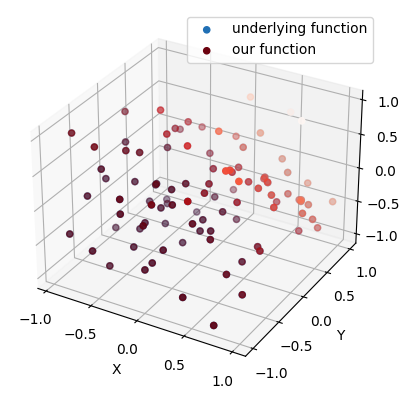

In [9]:
class Model:
  def __init__(self, input_dim, num_hidden1, num_hidden2):
    self.linear1 = Linear(input_dim, num_hidden1)
    self.relu1 = Relu()
    self.linear2 = Linear(num_hidden1, num_hidden2)
    self.relu2 = Relu()
    self.linear3 = Linear(num_hidden2, 1)

  def __call__(self, x):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3

  def backward(self, output_gradient):
    linear3_gradient = self.linear3.backward(output_gradient)
    relu2_gradient = self.relu2.backward(linear3_gradient)
    linear2_gradient = self.linear2.backward(relu2_gradient)
    relu1_gradient = self.relu1.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu1_gradient)
    # print('Model backward', linear2_gradient.shape, relu_gradient.shape, linear1_gradient.shape)
    # import pdb; pdb.set_trace()
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

loss = MSE()
model = Model(d,100,40)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
loss_gradient = loss.backward()
print(loss_value)
model.backward(loss_gradient)
plot_4d(x, y_true, y_pred)

Neural network for non-linear Regression

Activation function : Relu

Layers in neural network:

Input layer -> Hidden layer 1(100 neurons) -> Hidden layer 2(40 neurons) -> Output layers

Number of epochs : 1000

Epoch 0, loss 32.701995849609375
Epoch 1, loss 20.291765213012695
Epoch 2, loss 13.899298667907715
Epoch 3, loss 10.238702774047852
Epoch 4, loss 7.987026214599609
Epoch 5, loss 6.529202938079834
Epoch 6, loss 5.546807765960693
Epoch 7, loss 4.862809181213379
Epoch 8, loss 4.374001502990723
Epoch 9, loss 4.016615390777588
Epoch 10, loss 3.748140811920166
Epoch 11, loss 3.541994571685791
Epoch 12, loss 3.3802647590637207
Epoch 13, loss 3.2503480911254883
Epoch 14, loss 3.1436007022857666
Epoch 15, loss 3.0537405014038086
Epoch 16, loss 2.976471424102783
Epoch 17, loss 2.908708095550537
Epoch 18, loss 2.8480169773101807
Epoch 19, loss 2.792858839035034
Epoch 20, loss 2.7420501708984375
Epoch 21, loss 2.6947009563446045
Epoch 22, loss 2.650055170059204
Epoch 23, loss 2.607633352279663
Epoch 24, loss 2.567014694213867
Epoch 25, loss 2.5276951789855957
Epoch 26, loss 2.4897210597991943
Epoch 27, loss 2.452993154525757
Epoch 28, loss 2.417336940765381
Epoch 29, loss 2.3826894760131836
Epoch 

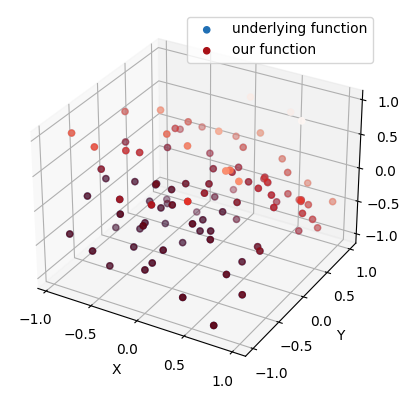

In [10]:
fit(x, y_true, model=model, loss=loss, lr=0.01, num_epochs=1000)
plot_4d(x, y_true, model(x))

Plotting 2d non linear quadratic equation data. Weights as 5,2

n denotes number of input data points

d denotes dimension

x is the set random n number of points generated in d dimensions

calculating actual values of y as y_true using x, actuals weights and bias

plotting x and y

In [11]:
def plot_3d(x, y, y_pred=None):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='our function')
  plt.legend()

x: (200, 2), weights: (2, 1), bias: (1,), y: (200, 1)


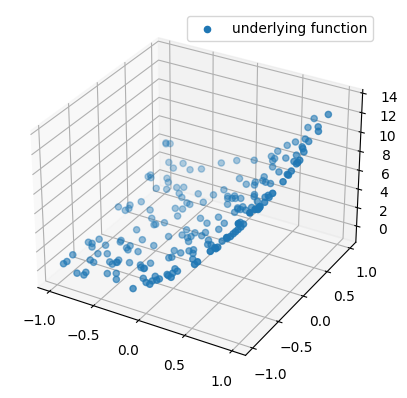

In [12]:
n = 200
d = 2
key = random.PRNGKey(0)
x = random.uniform(key, (n, d), minval=-1, maxval=1)

weights_true = jnp.array([[5, 2],]).T
bias_true = jnp.array([1])

y_true = (x ** 2) @ weights_true + x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

plot_3d(x, y_true)

Using Gradient descent and mean sum of square errors to calculate the loss and gradient, to update the weights and bias such that loss is minized

In [13]:
class MSE:
    def __call__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        return jnp.mean((y_pred - y_true) ** 2)

    def backward(self):
      n = self.y_true.shape[0]
      self.gradient = 2. * (self.y_pred - self.y_true) / n
      # print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
      return self.gradient



First the weights and bias are initialized to a random value

Then calculate output by multiplying input with weights and adding bias

In backward function, the weights gradient and bias gradient are calculated based on the gradient values calculated

The weights and bias values are then updated in the update method

In [14]:
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    key = random.PRNGKey(0)
    #x = random.uniform(key, (n, d), minval=-1, maxval=1)
    self.weights = random.uniform(key, (input_dim, num_hidden)) * jnp.sqrt(2. / input_dim)
    self.bias = jnp.zeros(num_hidden)

  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

In [15]:
from typing import Callable

def fit(x: jnp.ndarray, y: jnp.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

Training with linear function

Using the linear function to train the non-linear data results in the loss being high, because the linear function is incapable of representing the this data

Epoch 0, loss 22.36227035522461
Epoch 1, loss 17.229623794555664
Epoch 2, loss 13.679753303527832
Epoch 3, loss 11.179418563842773
Epoch 4, loss 9.382391929626465
Epoch 5, loss 8.06276798248291
Epoch 6, loss 7.07221794128418
Epoch 7, loss 6.312567234039307
Epoch 8, loss 5.718175411224365
Epoch 9, loss 5.244612693786621
Epoch 10, loss 4.8613505363464355
Epoch 11, loss 4.547048091888428
Epoch 12, loss 4.286494255065918
Epoch 13, loss 4.0686163902282715
Epoch 14, loss 3.885174512863159
Epoch 15, loss 3.729902505874634
Epoch 16, loss 3.59793758392334
Epoch 17, loss 3.4854300022125244
Epoch 18, loss 3.3892838954925537
Epoch 19, loss 3.306973695755005
Epoch 20, loss 3.2364137172698975
Epoch 21, loss 3.1758646965026855
Epoch 22, loss 3.1238677501678467
Epoch 23, loss 3.0791893005371094
Epoch 24, loss 3.040782928466797
Epoch 25, loss 3.0077579021453857
Epoch 26, loss 2.979353189468384
Epoch 27, loss 2.9549179077148438
Epoch 28, loss 2.933894634246826
Epoch 29, loss 2.915804386138916
Epoch 30, 

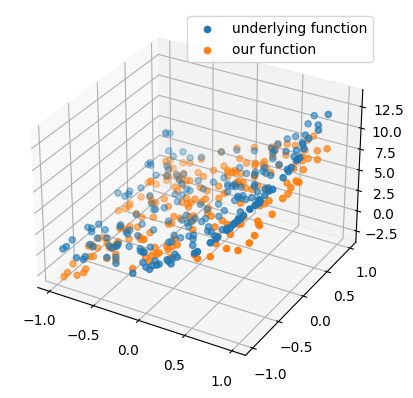

In [16]:
loss = MSE()
linear = Linear(d)
fit(x, y_true, model=linear, loss=loss, lr=0.1, num_epochs=40)
plot_3d(x, y_true, linear(x))

Introducing non-linearity in the neural network with a non-linear activation function - Relu. This enables the network to model complex relationships between input and output variables.

Without non-linear function, the output of each neuron would be a linear combination of the input variables - results in linear model - limitation in representing complex patterns in data

Some non-linear functions used : sigmoid, ReLU, Tanh.
Model complex relationships between input and output variables and learn more complex patterns in data

In [17]:
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = jnp.clip(self.input_, 0, None)
        return self.output

    def backward(self, output_gradient):
      #to debug
      #import pdb
      #pdb.set_trace()
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient


#relu = Relu()
#input_ = np.expand_dims(np.array([1, 0.5, 0, -0.5, -1]), -1)
#print(relu(input_))
#print(relu.backward(input_))

Performing just one step of:
- forward pass
- backward propagation

5.5205283


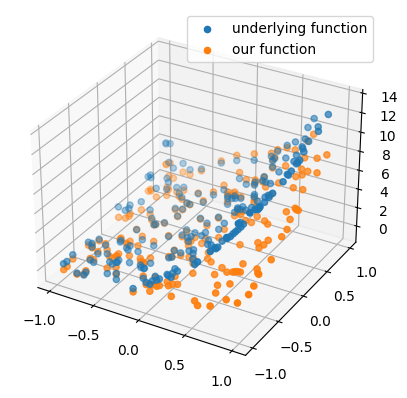

In [18]:
class Model:
  def __init__(self, input_dim, num_hidden1, num_hidden2):
    self.linear1 = Linear(input_dim, num_hidden1)
    self.relu1 = Relu()
    self.linear2 = Linear(num_hidden1, num_hidden2)
    self.relu2 = Relu()
    self.linear3 = Linear(num_hidden2, 1)

  def __call__(self, x):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3

  def backward(self, output_gradient):
    linear3_gradient = self.linear3.backward(output_gradient)
    relu2_gradient = self.relu2.backward(linear3_gradient)
    linear2_gradient = self.linear2.backward(relu2_gradient)
    relu1_gradient = self.relu1.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu1_gradient)
    # print('Model backward', linear2_gradient.shape, relu_gradient.shape, linear1_gradient.shape)
    # import pdb; pdb.set_trace()
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

loss = MSE()
model = Model(d, 20, 20)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
loss_gradient = loss.backward()
print(loss_value)
model.backward(loss_gradient)
plot_3d(x, y_true, y_pred)

Neural network for non-linear Regression

Activation function : Relu

Layers in neural network:

Input layer -> Hidden layer 1(20 neurons) -> Hidden layer 2(20 neurons) -> Output layers

Number of epochs : 100

Epoch 0, loss 5.520528316497803
Epoch 1, loss 5.0767130851745605
Epoch 2, loss 4.686609268188477
Epoch 3, loss 4.3478312492370605
Epoch 4, loss 4.053112506866455
Epoch 5, loss 3.794825315475464
Epoch 6, loss 3.5696306228637695
Epoch 7, loss 3.3715667724609375
Epoch 8, loss 3.1964662075042725
Epoch 9, loss 3.0417840480804443
Epoch 10, loss 2.904313802719116
Epoch 11, loss 2.7802484035491943
Epoch 12, loss 2.66806960105896
Epoch 13, loss 2.566101551055908
Epoch 14, loss 2.4724433422088623
Epoch 15, loss 2.3850669860839844
Epoch 16, loss 2.303751230239868
Epoch 17, loss 2.2276229858398438
Epoch 18, loss 2.1556520462036133
Epoch 19, loss 2.0878782272338867
Epoch 20, loss 2.023846387863159
Epoch 21, loss 1.9629937410354614
Epoch 22, loss 1.9053159952163696
Epoch 23, loss 1.8505382537841797
Epoch 24, loss 1.7983404397964478
Epoch 25, loss 1.7484716176986694
Epoch 26, loss 1.70074462890625
Epoch 27, loss 1.6551333665847778
Epoch 28, loss 1.6113537549972534
Epoch 29, loss 1.5691795349121094
Ep

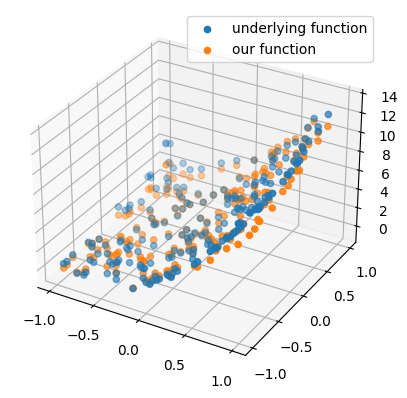

In [19]:
fit(x, y_true, model=model, loss=loss, lr=0.01, num_epochs=100)
plot_3d(x, y_true, model(x))